In [ ]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
base_path = "./"

import os
import cv2
import json
import numpy as np
import torch
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from torch.optim import AdamW
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm

import torch.backends.cudnn as cudnn
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
cudnn.deterministic = True
cudnn.benchmark = False

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# --- Configurations ---
model_path = "./GPU_trained_blade_model.pth"  # Update this to your trained SegFormer model directory
image_dir = "./single_image_result/img-6214.jpg"  # Update this to the directory containing input images
output_dir = "./"  # Directory where masked images will be saved
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_class = 1  # Change this if your blade class has a different index

# --- Load model and processor ---
base_model_name = "nvidia/mit-b3"
#feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b3")
model = SegformerForSemanticSegmentation.from_pretrained(base_model_name, num_labels=2, ignore_mismatched_sizes=True).to(device)
#optimizer = AdamW(model.parameters(), lr=5e-5)
#model_path = os.path.join(base_path, "GPU_trained_blade_model.pth")
model.load_state_dict(torch.load("GPU_trained_blade_model.pth", map_location="cpu"))
processor = SegformerImageProcessor.from_pretrained(base_model_name)
model.eval()


# --- Create output directory if not exists ---
os.makedirs(output_dir, exist_ok=True)

# --- Get list of image files ---
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# --- Inference loop ---
print(f"Loaded {len(image_files)} test images.")
for image_name in tqdm(image_files, desc="Processing"):
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image for the model
    inputs = processor(images=image_rgb, return_tensors="pt").to(device)

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits  # shape: [1, num_classes, height, width]
    preds = torch.argmax(logits, dim=1)[0].cpu().numpy().astype(np.uint8)

    # Generate binary mask for the blade class
    mask = (preds == target_class).astype(np.uint8) * 255  # mask values: 0 or 255

    # Optional: Smooth the mask using Gaussian blur
    mask = cv2.GaussianBlur(mask, (5, 5), 0)

    # Ensure mask is uint8
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

# Resize mask if necessary to match image shape
    if mask.shape != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Apply the mask to the original image: blade only, background black
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Save the result
    output_path = os.path.join(output_dir, image_name)
    cv2.imwrite(output_path, masked_image)





In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) 
                            for fname in os.listdir(image_dir) 
                            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # label is dummy for autoencoder

# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load dataset from folder without class structure
train_dataset = CustomImageDataset(image_dir='smoothed_masks', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Model, loss, optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if epoch % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), 'conv_autoencoder.pth')



Using device: cpu
Epoch [1/50], Loss: 0.2092
Epoch [6/50], Loss: 0.2025
Epoch [11/50], Loss: 0.1829
Epoch [16/50], Loss: 0.1284
Epoch [21/50], Loss: 0.0632
Epoch [26/50], Loss: 0.0265
Epoch [31/50], Loss: 0.0149
Epoch [36/50], Loss: 0.0105
Epoch [41/50], Loss: 0.0083
Epoch [46/50], Loss: 0.0073


<Figure size 1600x1200 with 0 Axes>

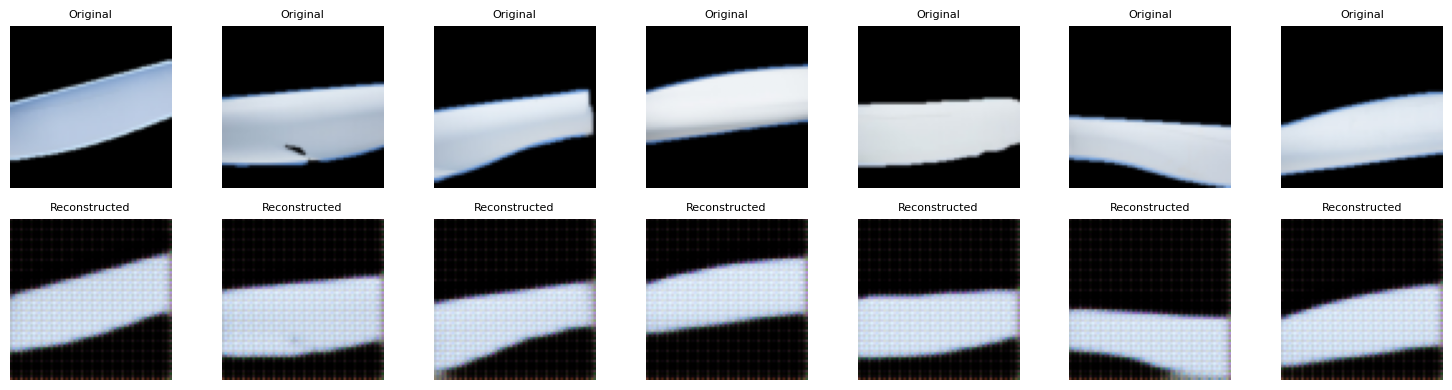

In [3]:
# Evaluate model on test data (or train data if no separate test set)
with torch.no_grad():
    for data, _ in train_loader:  # use test_loader if you have it
        data = data.to(device)
        recon = model(data)
        break  # visualize only the first batch

# Visualize original vs reconstructed images
import matplotlib.pyplot as plt

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].set_title("Original", fontsize=8)
    ax[1, i].set_title("Reconstructed", fontsize=8)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()


<Figure size 1600x1200 with 0 Axes>

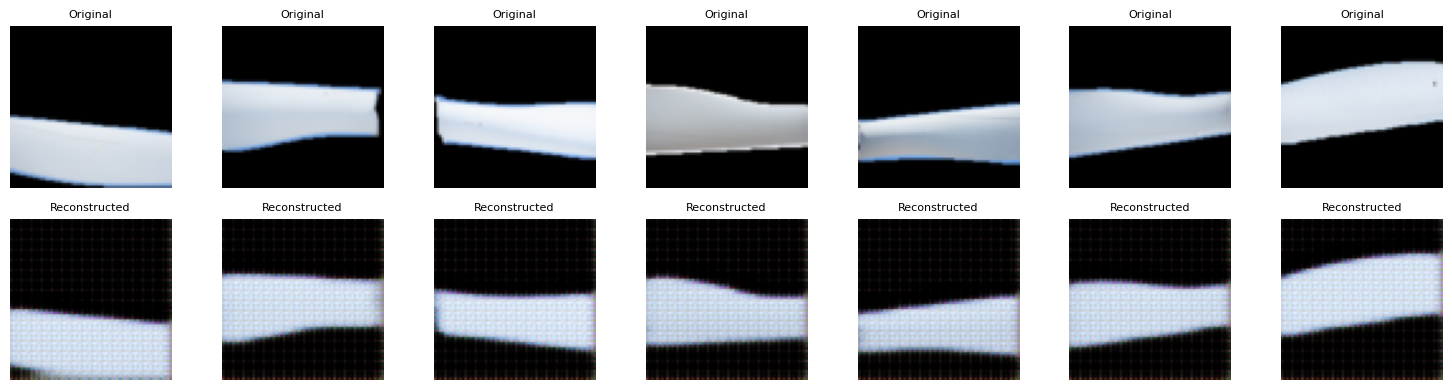

In [4]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

# Create folder to save results
save_dir = "reconstruction_results"
os.makedirs(save_dir, exist_ok=True)

# Evaluate model on sample batch
with torch.no_grad():
    for data, _ in train_loader:  # or test_loader if you have one
        data = data.to(device)
        recon = model(data)
        break

# Save individual original and reconstructed images
for i in range(min(7, data.size(0))):
    orig_img = data[i].cpu()
    recon_img = recon[i].cpu()

    #vutils.save_image(orig_img, os.path.join(save_dir, f"original_{i}.png"))
    vutils.save_image(recon_img, os.path.join(save_dir, f"reconstructed_{i}.png"))

# Also plot and show them
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].set_title("Original", fontsize=8)
    ax[1, i].set_title("Reconstructed", fontsize=8)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()


<Figure size 1600x1200 with 0 Axes>

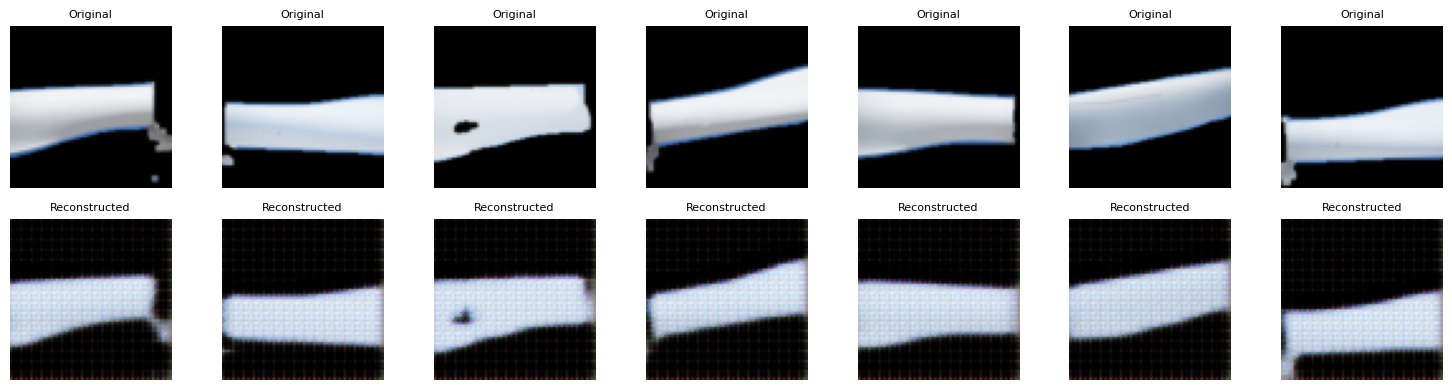

In [6]:
from torchvision.transforms.functional import to_pil_image
import os
from PIL import Image
import matplotlib.pyplot as plt

# Create folder to save results
save_dir = "reconstruction_results2"
os.makedirs(save_dir, exist_ok=True)

# Inference on a single batch
with torch.no_grad():
    for data, _ in train_loader:  # or test_loader if available
        data = data.to(device)
        recon = model(data)
        break

# Save the original and reconstructed images preserving specs
for i in range(min(7, data.size(0))):
    orig_img_tensor = data[i].cpu().clamp(0, 1)  # Clamp in case of small overflow
    recon_img_tensor = recon[i].cpu().clamp(0, 1)

    orig_img = to_pil_image(orig_img_tensor)
    recon_img = to_pil_image(recon_img_tensor)

    orig_img.save(os.path.join(save_dir, f"original_{i}.png"))
    recon_img.save(os.path.join(save_dir, f"reconstructed_{i}.png"))

# Also show them side by side
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(to_pil_image(data[i].cpu()))
    ax[1, i].imshow(to_pil_image(recon[i].cpu()))
    ax[0, i].set_title("Original", fontsize=8)
    ax[1, i].set_title("Reconstructed", fontsize=8)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()


In [7]:
from torchvision.transforms import Resize, ToPILImage

resize_to = Resize((256, 256))  # You can change this to any larger size
to_pil = ToPILImage()

for i in range(min(7, data.size(0))):
    orig_img_tensor = data[i].cpu().clamp(0, 1)
    recon_img_tensor = recon[i].cpu().clamp(0, 1)

    # Resize before converting to PIL image
    orig_img = to_pil(resize_to(orig_img_tensor))
    recon_img = to_pil(resize_to(recon_img_tensor))

    orig_img.save(os.path.join(save_dir, f"original_{i}.png"))
    recon_img.save(os.path.join(save_dir, f"reconstructed_{i}.png"))


<Figure size 1600x1200 with 0 Axes>

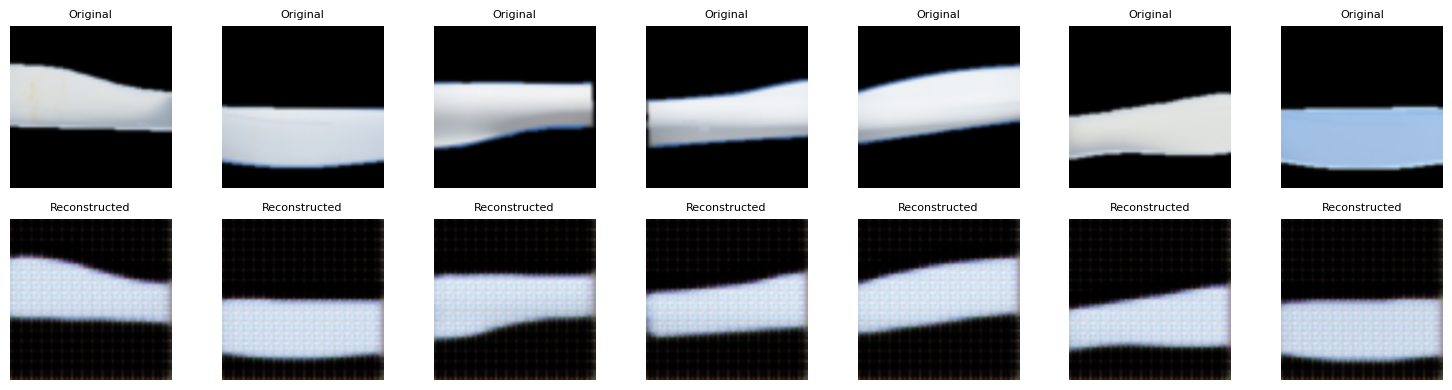

In [8]:
from torchvision.transforms import Resize, ToPILImage
import os
import matplotlib.pyplot as plt

# Create folder to save results
save_dir = "reconstruction_results"
os.makedirs(save_dir, exist_ok=True)

# Resize and PIL transforms
resize_to = Resize((256, 256))
to_pil = ToPILImage()

# Evaluate on a batch
with torch.no_grad():
    for data, _ in train_loader:  # or test_loader
        data = data.to(device)
        recon = model(data)
        break

# Save original and reconstructed images as 256x256 PNGs
for i in range(min(7, data.size(0))):
    orig_img_tensor = data[i].cpu().clamp(0, 1)
    recon_img_tensor = recon[i].cpu().clamp(0, 1)

    # Resize before converting to PIL Image
    orig_img_resized = to_pil(resize_to(orig_img_tensor))
    recon_img_resized = to_pil(resize_to(recon_img_tensor))

    orig_img_resized.save(os.path.join(save_dir, f"original_{i}.png"))
    recon_img_resized.save(os.path.join(save_dir, f"reconstructed_{i}.png"))

# Also plot them for quick visual inspection
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    upsampled_orig = resize_to(data[i].cpu().clamp(0, 1))
    upsampled_recon = resize_to(recon[i].cpu().clamp(0, 1))

    ax[0, i].imshow(upsampled_orig.permute(1, 2, 0))
    ax[1, i].imshow(upsampled_recon.permute(1, 2, 0))
    ax[0, i].set_title("Original", fontsize=8)
    ax[1, i].set_title("Reconstructed", fontsize=8)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()


<Figure size 1600x1200 with 0 Axes>

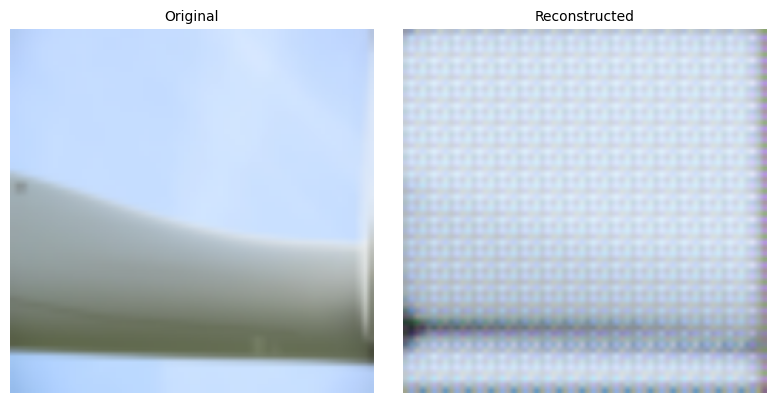

In [10]:
from PIL import Image
from torchvision import transforms
import torch
import os
import matplotlib.pyplot as plt

# Define transforms
input_size = (64, 64)
display_size = (256, 256)

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor()
])

resize_to = transforms.Resize(display_size)
to_pil = transforms.ToPILImage()

# Load single image
image_path = 'img-6214.jpg'  # <-- Replace with your image path
img = Image.open(image_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Load model and run inference
model.eval()
with torch.no_grad():
    output_tensor = model(input_tensor)

# Remove batch dimension and clamp values
input_img = input_tensor[0].cpu().clamp(0, 1)
output_img = output_tensor[0].cpu().clamp(0, 1)

# Resize and convert to PIL for saving
input_img_resized = to_pil(resize_to(input_img))
output_img_resized = to_pil(resize_to(output_img))

# Save to folder
save_dir = "single_image_result"
os.makedirs(save_dir, exist_ok=True)
input_img_resized.save(os.path.join(save_dir, "original.png"))
output_img_resized.save(os.path.join(save_dir, "reconstructed.png"))

# Display side-by-side
plt.figure(dpi=250)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(input_img_resized)
ax[1].imshow(output_img_resized)
ax[0].set_title("Original", fontsize=10)
ax[1].set_title("Reconstructed", fontsize=10)
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()
plt.show()
